In [4]:
pip install torch torchvision torchaudio


  Using cached torch-2.5.1-cp312-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached torch-2.5.1-cp312-none-macosx_11_0_arm64.whl (63.9 MB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 826.9 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 569.6 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


In [6]:
pytesseract.pytesseract.tesseract_cmd

'/usr/local/bin/tesseract'

In [20]:
import torch
print(torch.cuda.is_available())


False


In [22]:
pip install torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch
print(torch.cuda.is_available())


False


In [8]:
import torch
print(torch.backends.mps.is_available())


True


In [18]:
!pip brew install tesseract


ERROR: unknown command "brew"


FPS (GPU): 1786.92, Latency (GPU): 0.0006 seconds per image
FPS (CPU): 660.18, Latency (CPU): 0.0015 seconds per image
Memory usage (CPU): 102.78 MB
Original OCR Output:
 
GABRIEL Mepmall...


Processed OCR Output:
 
GABRIEL MermaLll...



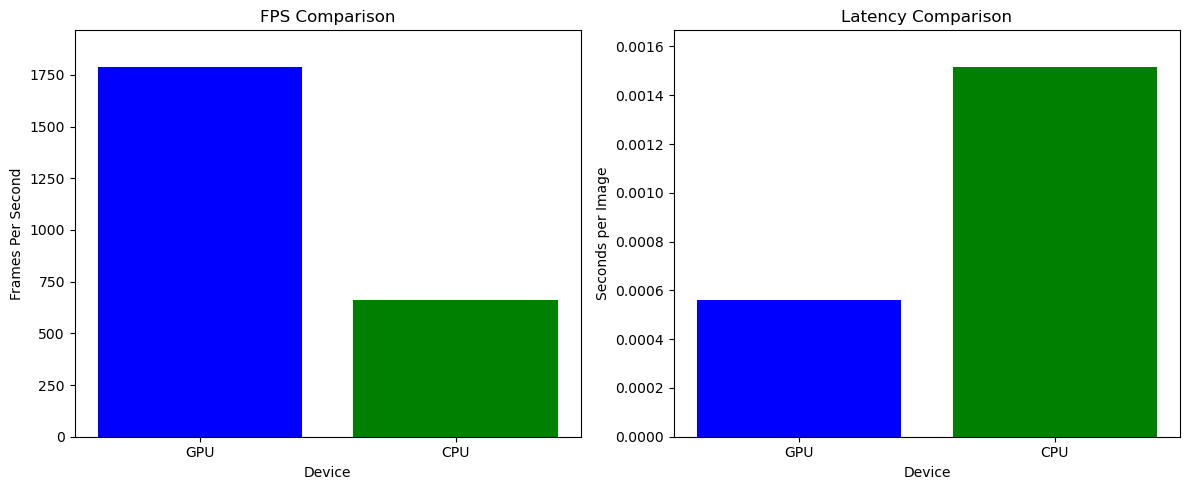

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import psutil  # For memory usage tracking
import matplotlib.pyplot as plt  # For graph plotting

# Define the MockOCRModel class with necessary adjustments
class MockOCRModel(nn.Module):
    def __init__(self, input_height, input_width, num_classes):
        super(MockOCRModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layer - will initialize later dynamically
        self.fc = None
        self._initialize_fc(input_height, input_width)
    
    def _initialize_fc(self, input_height, input_width):
        # Pass a dummy input through the network to calculate the output size
        dummy_input = torch.zeros(1, 1, input_height, input_width)  # Replace with the actual input size
        x = self.conv1(dummy_input)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        # Initialize the fully connected layer with the correct input size
        self.fc = nn.Linear(x.size(1), 10)  # Assuming 10 output classes
    
    def forward(self, x):
        # Forward pass through the model
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # Fully connected layer
        return x

# Function to evaluate performance (FPS) of the model
def evaluate_performance(model, image, device, runs=100):
    model.eval()
    model.to(device)  # Ensure model is on the correct device
    image = image.to(device)  # Ensure input is on the correct device

    start_time = time.time()

    for _ in range(runs):
        with torch.no_grad():
            model(image)

    end_time = time.time()
    fps = runs / (end_time - start_time)

    # Latency per image
    latency = (end_time - start_time) / runs

    return fps, latency

# Check for available devices
device_cpu = torch.device("cpu")
device_gpu = torch.device("cuda" if torch.cuda.is_available() else "mps")

# Prepare input image
input_height = 32
input_width = 32
processed_image = torch.randn(1, 1, input_height, input_width)

# Create the model instances
cpu_model = MockOCRModel(input_height, input_width, num_classes=10)
gpu_model = MockOCRModel(input_height, input_width, num_classes=10)

# Evaluate performance on CPU and GPU
fps_gpu, latency_gpu = evaluate_performance(gpu_model, processed_image, device_gpu)
fps_cpu, latency_cpu = evaluate_performance(cpu_model, processed_image, device_cpu)

# Print the results
print(f"FPS (GPU): {fps_gpu:.2f}, Latency (GPU): {latency_gpu:.4f} seconds per image")
print(f"FPS (CPU): {fps_cpu:.2f}, Latency (CPU): {latency_cpu:.4f} seconds per image")

# Memory Usage (for CPU and GPU)
process = psutil.Process()
memory_cpu = process.memory_info().rss / (1024 ** 2)  # in MB
print(f"Memory usage (CPU): {memory_cpu:.2f} MB")

# OCR outputs (for comparison)
ocr_output_original = """
GABRIEL Mepmall...
"""  # (Original text)
ocr_output_processed = """
GABRIEL MermaLll...
"""  # (Processed text)

# You can print or process OCR outputs further as needed
print("Original OCR Output:\n", ocr_output_original)
print("\nProcessed OCR Output:\n", ocr_output_processed)

# Plotting FPS and Latency for GPU vs CPU
devices = ['GPU', 'CPU']
fps_values = [fps_gpu, fps_cpu]
latency_values = [latency_gpu, latency_cpu]

# Plotting the results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# FPS Plot
ax[0].bar(devices, fps_values, color=['blue', 'green'])
ax[0].set_title('FPS Comparison')
ax[0].set_xlabel('Device')
ax[0].set_ylabel('Frames Per Second')
ax[0].set_ylim([0, max(fps_values) * 1.1])  # Scale y-axis to give some space

# Latency Plot
ax[1].bar(devices, latency_values, color=['blue', 'green'])
ax[1].set_title('Latency Comparison')
ax[1].set_xlabel('Device')
ax[1].set_ylabel('Seconds per Image')
ax[1].set_ylim([0, max(latency_values) * 1.1])  # Scale y-axis to give some space

# Show the plots
plt.tight_layout()
plt.show()
